In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
tqdm.pandas(desc = 'progress-bad')

from sklearn import utils
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument


import re
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
nltk.download('punkt')
from textblob import TextBlob
from textblob import Word

from bs4 import BeautifulSoup

[nltk_data] Downloading package punkt to /home/sunbeam/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## FOR IMPORTING THE TRAINING PART DATA IN NOSQL
* mongoimport -d sentiment_analysis -c trainingOrignal --headerline --type=csv ~/PycharmProjects/FinalProject/all-data.csv  --> For Importing the Data

## FOR IMPORTING THE CRAWLED PART DATA IN NOSQL
* mongoimport -d sentiment_analysis -c crawled --headerline --type=csv ~/PycharmProjects/FinalProject/final_all_data1.csv  for importing the crawled data


In [2]:
import pymongo
from pymongo import MongoClient

client = MongoClient("mongodb://localhost:27017")
db = client['sentiment_analysis']

In [3]:
#LOADING THE TRAINING PART PSUEDO DATA IN pandas From NoSql
df_orignal = db['trainingOrignal'].find({},{"_id": 0,"label" : 1, "content" : 1})
df_orignal = pd.DataFrame(df_orignal)

In [4]:
df_orignal.head()

,label,content
0,neutral,"According to Gran , the company has no plans t..."
1,negative,The international electronic industry company ...
2,neutral,Technopolis plans to develop in stages an area...
3,positive,According to the company 's updated strategy f...
4,positive,With the new production plant the company woul...


In [5]:
df_orignal.count()

label      4846
content    4846
dtype: int64

In [6]:
#LOADING THE Crawled Part PSUEDO DATA IN Pandas From NoSql
df_crawled = db['crawled'].find({},{"_id": 0,"label" : 1, "content" : 1})
df_crawled = pd.DataFrame(df_crawled)

In [7]:
df_crawled.head()

,label,content
0,positive,It has been an interesting time for stay-at-ho...
1,positive,Netflix (NASDAQ: NFLX) still commands the fiel...
2,neutral,
3,positive,Netflix (NASDAQ: NFLX) enacted price increases...
4,neutral,Individual investors have access to a nearly i...


In [8]:
df_crawled.count()

label      1245
content    1245
dtype: int64

## Cleaning Begins

In [9]:
df_orignal.isna().sum()

label      0
content    0
dtype: int64

In [10]:
df_crawled[df_crawled['content'] == ''].count()

label      407
content    407
dtype: int64

In [11]:
df_crawled = df_crawled[df_crawled['content'] != '']

In [12]:
df_crawled[df_crawled['content'] == ''].count()

label      0
content    0
dtype: int64

In [13]:
nltk.download('wordnet')
x = TextBlob("this year feels really really bad, i hope it doesnt get any worse")

[nltk_data] Downloading package wordnet to /home/sunbeam/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
x.sentiment

Sentiment(polarity=-0.5499999999999999, subjectivity=0.6333333333333333)

### LOlk

In [15]:
y = Word("playing")
y.lemmatize()

'playing'

In [16]:
y

'playing'

In [17]:
df_crawled.isna().sum()

label      0
content    0
dtype: int64

In [18]:
df_crawled['polarity'] = df_crawled['content'].apply(lambda x: TextBlob(Word(x).lemmatize()).sentiment[0])
df_crawled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 838 entries, 0 to 1243
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   label     838 non-null    object 
 1   content   838 non-null    object 
 2   polarity  838 non-null    float64
dtypes: float64(1), object(2)
memory usage: 26.2+ KB


In [19]:
df_crawled.loc[df_crawled.polarity < 0 ,'label'] = 'negative'
df_crawled.loc[df_crawled.polarity > 0 ,'label'] = 'positive'
df_crawled.loc[df_crawled.polarity == 0 ,'label'] = 'neutral'
df_crawled.drop('polarity',axis = 1,inplace = True)
df_crawled.head()

,label,content
0,positive,It has been an interesting time for stay-at-ho...
1,neutral,Netflix (NASDAQ: NFLX) still commands the fiel...
3,positive,Netflix (NASDAQ: NFLX) enacted price increases...
4,positive,Individual investors have access to a nearly i...
5,neutral,"BENGALURU, Jan 13 (Reuters) - Amazon.com AMZN...."


In [20]:
df_orignal[['label','content']].groupby(['label']).agg(['count'])

,content
,count
label,
negative,604
neutral,2879
positive,1363


<AxesSubplot:xlabel='label', ylabel='count'>

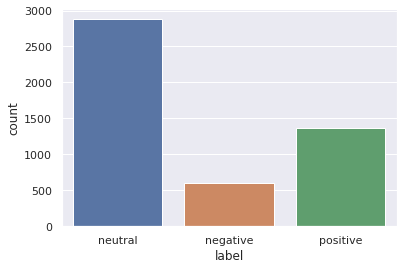

In [21]:
sns.set_theme(style = 'darkgrid')
sns.countplot(x = 'label', data = df_orignal)

In [22]:
df_crawled[['label','content']].groupby(['label']).agg(['count'])

,content
,count
label,
negative,118
neutral,273
positive,447


<AxesSubplot:xlabel='label', ylabel='count'>

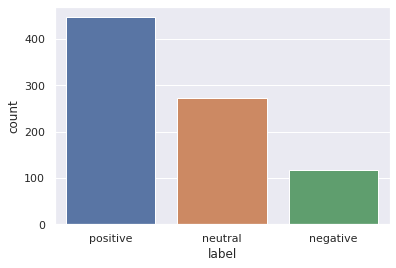

In [23]:
sns.set_theme(style = 'darkgrid')
sns.countplot(x = 'label', data = df_crawled)

In [24]:
df = pd.concat([df_orignal,df_crawled])

In [25]:
df.count()

label      5684
content    5684
dtype: int64

In [26]:
from sklearn.utils import shuffle
df = shuffle(df)
df = df.reset_index()

In [27]:
results = df[['label','content']].groupby(['label']).agg(['count'])
results

,content
,count
label,
negative,722
neutral,3152
positive,1810


In [28]:
df.head()

,index,label,content
0,2213,neutral,The company also said that its board of direct...
1,1823,positive,`` We are delighted to welcome Elisa to our Bo...
2,425,neutral,Jan 4 (Reuters) - Media giant ViacomCBS Inc VI...
3,1616,neutral,The board of directors also proposed that a di...
4,1544,positive,It also has strong assets in electronic media ...


<AxesSubplot:xlabel='label', ylabel='count'>

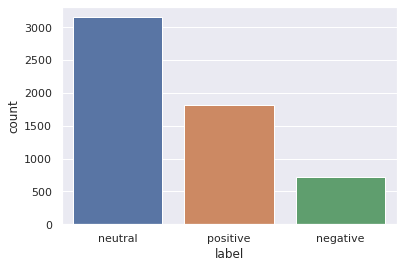

In [29]:
sns.set_theme(style = 'darkgrid')
sns.countplot(x = 'label', data = df)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5684 entries, 0 to 5683
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   index    5684 non-null   int64 
 1   label    5684 non-null   object
 2   content  5684 non-null   object
dtypes: int64(1), object(2)
memory usage: 133.3+ KB


In [31]:
df

,index,label,content
0,2213,neutral,The company also said that its board of direct...
1,1823,positive,`` We are delighted to welcome Elisa to our Bo...
2,425,neutral,Jan 4 (Reuters) - Media giant ViacomCBS Inc VI...
3,1616,neutral,The board of directors also proposed that a di...
4,1544,positive,It also has strong assets in electronic media ...
...,...,...,...
5679,700,negative,Profit before taxes decreased to EUR 31.6 mn f...
5680,1558,neutral,The fine print is here .
5681,1236,neutral,"Glaston 's well-known brands are Bavelloni , i..."
5682,782,positive,Thanksto improvements in demand and the adjust...


In [32]:
## Importing this data to  NoSQl
import_data = df.reset_index()
data_dict = df.to_dict('records')
client = MongoClient('mongodb://localhost:27017')
db = client['sentiment_analysis']
data = db['final_data_sentiment']
data.insert_many(data_dict)

<AxesSubplot:xlabel='label', ylabel='count'>

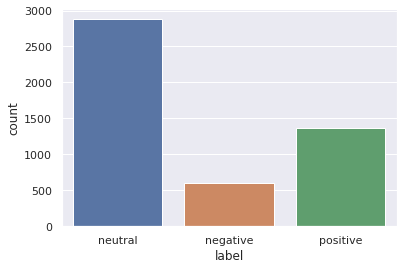

In [33]:
sns.set_theme(style = 'darkgrid')
sns.countplot(x = 'label', data = df_orignal)

In [34]:
sentiment  = {'positive': 0,'neutral': 1,'negative':2} 
df_orignal.loc[df_orignal.label == 'negative' ,'label'] = 2
df_orignal.loc[df_orignal.label == 'neutral' ,'label'] = 1
df_orignal.loc[df_orignal.label == 'positive' ,'label'] = 0

In [35]:
df_orignal

,label,content
0,1,"According to Gran , the company has no plans t..."
1,2,The international electronic industry company ...
2,1,Technopolis plans to develop in stages an area...
3,0,According to the company 's updated strategy f...
4,0,With the new production plant the company woul...
...,...,...
4841,2,The company said that its comparable operating...
4842,1,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4843,2,Operating profit fell to EUR 35.4 mn from EUR ...
4844,2,Net sales of the Paper segment decreased to EU...


In [36]:
def cleanText(text):
    text = BeautifulSoup(text, "html.parser").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text

In [37]:
df_orignal['content'] = df_orignal['content'].apply(lambda x : cleanText(x))

In [38]:
train, test = train_test_split(df_orignal, test_size=0.000001)

In [39]:
import nltk
from nltk.corpus import stopwords
def tokenize_text(text):
    tokens = [words.lower() for sentences in nltk.sent_tokenize(text) for words in nltk.word_tokenize(sentences) if len(words) !=0   ]
    return tokens

In [40]:
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['content']), tags=[r.label]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['content']), tags=[r.label]), axis=1)

In [41]:
# maximum number of words in each content/article.
MAX_SEQUENCE_LENGTH = 50

tokenizer = Tokenizer(num_words=700000, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df_orignal['content'].values)
X = tokenizer.texts_to_sequences(df_orignal['content'].values)
X = pad_sequences(X)

In [42]:
X.shape

(4846, 71)

In [43]:
X = tokenizer.texts_to_sequences(df_orignal['content'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)
X

Shape of data tensor: (4846, 50)


array([[   0,    0,    0, ...,   11,   10,  746],
       [   0,    0,    0, ...,  875, 5005,  251],
       [   0,    0,    0, ...,    1,  928,   20],
       ...,
       [   0,    0,    0, ...,  129,   38,   23],
       [   0,    0,    0, ...,   57,   54,   23],
       [   0,    0,    0, ...,  961,   18,  295]], dtype=int32)

In [44]:
train_tagged.values

array([TaggedDocument(words=['to', 'raise', 'consumer', 'awareness', 'and', 'encourage', 'people', 'to', 'recycle', 'their', 'old', 'mobile', 'devices', 'nokia', 'runs', 'regular', 'recycling', 'campaigns', 'around', 'the', 'world', '.'], tags=[1]),
       TaggedDocument(words=['bluewin', 'security', 'is', 'available', 'as', 'a', 'monthly', 'subscription', '.'], tags=[1]),
       TaggedDocument(words=['this', 'pc', 'application', 'allows', 'users', 'to', 'copy', 'files', 'and', 'other', 'data', 'from', 'their', 'nokia', 'mobile', 'device', 'to', 'their', 'computer', 'as', 'well', 'as', 'create', 'backup', 'content', '.'], tags=[1]),
       ...,
       TaggedDocument(words=['finnish', 'investor', 'scanfil', 'oyj', '(', 'hel', ':', 'scf1v', ')', 'said', 'last', 'friday', 'it', 'has', 'bought', '57', 'million', 'shares', ',', 'or', '32.96', '%', ',', 'in', 'norwegian', 'contract', 'electronics', 'manufacturer', 'kitron', 'asa', '(', 'osl', ':', 'kit', ')', 'for', 'nok', '143.9', 'million'

In [45]:
d2v_model = Doc2Vec(dm=1, dm_mean=1, size=20, window=8, min_count=1, workers=1, alpha=0.065, min_alpha=0.065)
d2v_model.build_vocab([x for x in tqdm(train_tagged.values)])

/home/sunbeam/anaconda3/envs/FinalProject/lib/python3.8/site-packages/gensim/models/doc2vec.py:319: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
100%|██████████| 4845/4845 [00:00<00:00, 538272.53it/s]


In [46]:
for epoch in range(30):
    d2v_model.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    d2v_model.alpha -= 0.002
    d2v_model.min_alpha = d2v_model.alpha

100%|██████████| 4845/4845 [00:00<00:00, 1535313.00it/s]


In [47]:
d2v_model
embedding_matrix = np.zeros((len(d2v_model.wv.vocab)+ 1, 20))

for i, vec in enumerate(d2v_model.docvecs.vectors_docs):
    while i in vec <= 1000:
          embedding_matrix[i]=vec
    print(vec)

[-4.947864   -3.4131618  -1.511144    2.578463   -0.9547782   6.1803837
 -4.2954264   2.301165    0.4313096  -4.8369994  -0.67284596 -1.5662407
 -7.567839    4.0707145   6.261236    3.8266735   2.4871726  -3.3369637
 -4.762957    3.3090012 ]
[-3.4859293  -1.6699038   1.3040285  -1.5394145   2.3333714   1.551482
  3.314991   -0.6250515   1.5844711  -1.199492    4.5319424  -1.8341707
  3.712625    3.273756    0.56078964  2.816525    1.5393033   5.5444117
  4.8487635  -0.3063976 ]
[-3.6991394  -3.0188396  -7.17932     2.3988383   8.5704565   6.137177
 -0.5367055  -9.127294    0.9669816  -0.15506572  5.988569    2.884322
  9.118181   -2.8873186   4.8813586  -0.01835752 -2.2048576  -5.9433894
 -1.0533581  -3.4842098 ]


In [48]:
print(d2v_model.wv.most_similar(positive=['profit'], topn=10))
print(d2v_model.wv.most_similar(positive=['investment'], topn=10))
print(d2v_model.wv.most_similar(positive=['broke'], topn=10))

[('loss', 0.9143661260604858), ('sales', 0.8183176517486572), ('larger-than-epected', 0.8042643666267395), ('income', 0.7908720970153809), ('turnover', 0.7415345907211304), ('profits', 0.7341822981834412), ('58.7', 0.6911219358444214), ('j.', 0.6858500242233276), ('12.9', 0.6818443536758423), ('73,297', 0.6656666994094849)]
[('organization', 0.7860656976699829), ('syndicated', 0.721613883972168), ('skogster', 0.7153177261352539), ('pension', 0.7033446431159973), ('buyer', 0.7029633522033691), ('op-pohjola', 0.7014364004135132), ('reserved', 0.668174147605896), ('scanfil', 0.6676497459411621), ('detailing', 0.6676387190818787), ('8,000', 0.6610368490219116)]
[('mold', 0.9735038876533508), ('my', 0.8963512182235718), ('pleased', 0.8899655342102051), ('finger-friendly', 0.8541820049285889), ('aptly', 0.8405840396881104), ('warmly', 0.8307619094848633), ('want', 0.82183837890625), ("'m", 0.821485161781311), ('perspective', 0.8214435577392578), ('gather', 0.8153660893440247)]


In [49]:
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding
import tensorflow as tf

In [50]:
model = Sequential()
model.add(Embedding(len(d2v_model.wv.vocab)+1,20,input_length=X.shape[1],weights=[embedding_matrix],trainable=True))

#correlations
def split_input(sequence):
     return sequence[:-1], tf.reshape(sequence[1:], (-1,1))

model.add(LSTM(50,return_sequences=False))
model.add(Dense(3,activation="softmax"))

# output model skeleton
model.summary()
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=['acc'])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 20)            233520    
_________________________________________________________________
lstm (LSTM)                  (None, 50)                14200     
_________________________________________________________________
dense (Dense)                (None, 3)                 153       
Total params: 247,873
Trainable params: 247,873
Non-trainable params: 0
_________________________________________________________________


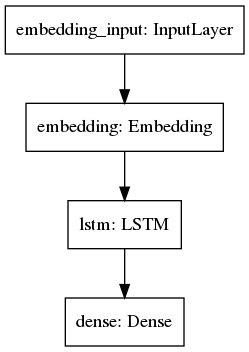

In [51]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

In [56]:
Y = pd.get_dummies(df_orignal['label']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.15, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(4119, 50) (4119, 3)
(727, 50) (727, 3)


In [57]:
history=model.fit(X_train, Y_train, epochs =50, batch_size=32, verbose = 2)

Epoch 1/50
129/129 - 3s - loss: 0.5251 - acc: 0.6159
Epoch 2/50
129/129 - 3s - loss: 0.3796 - acc: 0.7254
Epoch 3/50
129/129 - 4s - loss: 0.2637 - acc: 0.8145
Epoch 4/50
129/129 - 5s - loss: 0.1616 - acc: 0.9041
Epoch 5/50
129/129 - 4s - loss: 0.0884 - acc: 0.9558
Epoch 6/50
129/129 - 5s - loss: 0.0531 - acc: 0.9762
Epoch 7/50
129/129 - 4s - loss: 0.0423 - acc: 0.9823
Epoch 8/50
129/129 - 5s - loss: 0.0283 - acc: 0.9874
Epoch 9/50
129/129 - 4s - loss: 0.0279 - acc: 0.9886
Epoch 10/50
129/129 - 4s - loss: 0.0288 - acc: 0.9874
Epoch 11/50
129/129 - 4s - loss: 0.0195 - acc: 0.9917
Epoch 12/50
129/129 - 4s - loss: 0.0115 - acc: 0.9949
Epoch 13/50
129/129 - 3s - loss: 0.0127 - acc: 0.9947
Epoch 14/50
129/129 - 4s - loss: 0.0139 - acc: 0.9925
Epoch 15/50
129/129 - 4s - loss: 0.0079 - acc: 0.9968
Epoch 16/50
129/129 - 3s - loss: 0.0085 - acc: 0.9954
Epoch 17/50
129/129 - 3s - loss: 0.0090 - acc: 0.9964
Epoch 18/50
129/129 - 3s - loss: 0.0063 - acc: 0.9978
Epoch 19/50
129/129 - 4s - loss: 0.00

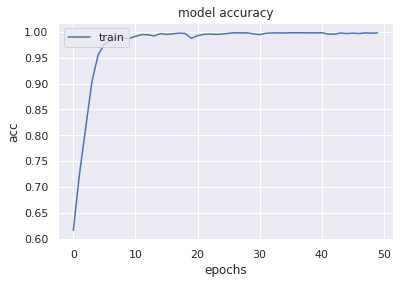

<Figure size 432x288 with 0 Axes>

In [58]:
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model_accuracy.png')

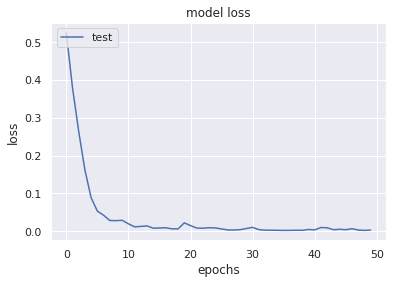

<Figure size 432x288 with 0 Axes>

In [76]:
# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['test', 'train'], loc='upper left')
plt.show()
plt.savefig('model_loss.png')

In [60]:
# evaluate the model
_, train_acc = model.evaluate(X_train, Y_train, verbose=2)
_, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print('Train: %.3f, Test: %.4f' % (train_acc, test_acc))

129/129 - 1s - loss: 0.0013 - acc: 0.9990
23/23 - 0s - loss: 1.2036 - acc: 0.7194
Train: 0.999, Test: 0.7194


In [64]:
# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
print(yhat_probs)

# predict crisp classes for test set
yhat_classes = model.predict_classes(X_test, verbose=0)
print(yhat_classes)

[[1.3610005e-06 9.9999750e-01 1.1893135e-06]
 [9.2152166e-01 7.6287813e-02 2.1904500e-03]
 [9.9807990e-01 1.4814080e-03 4.3865346e-04]
 ...
 [9.9976689e-01 9.4900512e-05 1.3819260e-04]
 [9.9995017e-01 2.6362804e-05 2.3486147e-05]
 [9.9997211e-01 9.1489728e-06 1.8756547e-05]]
Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
[1 0 0 1 1 1 0 1 2 1 1 1 1 1 1 1 1 1 1 1 2 1 0 1 1 1 1 1 1 1 1 1 1 2 0 0 2
 0 1 1 0 0 1 1 0 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 0 0 0 1 0 1 1 1 1 1 0 0 1 1
 0 1 1 1 1 0 2 0 0 0 0 1 1 0 0 0 0 1 1 2 1 1 1 1 0 1 1 0 2 0 1 0 0 0 1 2 1
 0 2 0 1 0 0 0 0 0 0 1 1 1 1 1 0 1 0 1 2 0 1 1 0 0 1 1 1 0 1 1 0 1 1 1 1 1
 1 0 0 0 1 0 0 0 0 1 2 2 0 0 0 2 1 0 1 1 1 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 1
 2 0 2 1 1 0 1 

In [86]:
import numpy as np
rounded_labels=np.argmax(Y_test, axis=1)

In [85]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(rounded_labels, yhat_classes)
cm

array([[143,  68,  13],
       [ 70, 330,  13],
       [ 18,  22,  50]])

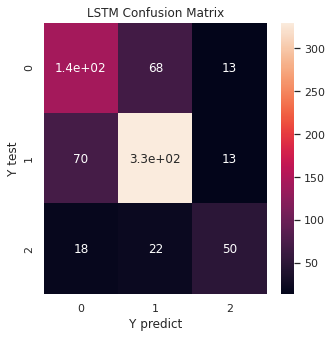

In [84]:
# The confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

lstm_val = confusion_matrix(rounded_labels, yhat_classes)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(lstm_val, annot=True)
plt.title('LSTM Confusion Matrix')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.savefig('confusion_matrix.png')
plt.show()

## Predicting sentiments on the Crawled Data Now

In [70]:
model.save('Mymodel.h5')

In [71]:
message = ['Shares of digital radio specialist Sirius XM Radio (NASDAQ: SIRI) fell 10.9% in calendar year 2020, according to data from S&P Global Market Intelligence. The stock never made a full recovery from the COVID-19 market panic in March.']
seq = tokenizer.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)
pred = model.predict(padded)
labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])

[[0.00522209 0.00666967 0.9881082 ]] 2


In [73]:
df = pd.read_csv('tests_json1.csv')
df.dropna(inplace=True)
labels = ['0', '1', '2']
y = []

pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option("display.max_rows", 999)

In [74]:
def sentiment_producer(content):
    seq = tokenizer.texts_to_sequences([content])
    padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH, dtype='int32', value=0)
    pred = model.predict(padded)
    return labels[np.argmax(pred)]

In [77]:
client = MongoClient('mongodb://localhost:27017')
db = client['sentiment_analysis']
data = db['final_data_sentiment']

#LOADING THE TRAINING PART PSUEDO DATA IN pandas From NoSql
df_topred = db['crawled_data_pred'].find({},{"_id": 0,"date" : 1, "content" : 1})
df_topred = pd.DataFrame(df_topred)

In [81]:
df_topred['sentiments'] = df_topred['content'].apply(lambda x : sentiment_producer(x))
df_topred

,date,content,sentiments
0,2021-01-13,"Walt Disney (NYSE: DIS) blew away all expectations with its Disney+ streaming service, both its own and those of analysts. Subscriber counts the entertainment giant thought it would take years to reach occurred in just months.",1
1,2021-01-12,"Shares of Zomedica Pharmaceuticals (NYSEMKT: ZOM) continued their recent rapid ascent on Tuesday. As of 11:33 a.m. EST, the veterinary health company's stock price is up more than 40%.",0
2,2021-01-12,"Both Netflix (NASDAQ: NFLX) and Amazon (NASDAQ: AMZN) are fantastic companies with bright futures. They've already created a ton of wealth for investors, and both have tons of growth left in their tanks. If you own one of them but not the other, go ahead and fix that error right now. Those who own neither should really pick up both. The only way not to win is not to play, if I may paraphrase WarGames.",0
3,2021-01-12,"InvestorPlace - Stock Market News, Stock Advice & Trading Tips",0
4,2021-01-11,"Three years ago, Amazon (NASDAQ: AMZN), Berkshire Hathaway (NYSE: BRK-A) (NYSE: BRK-B), and JPMorgan Chase (NYSE: JPM) announced a partnership that would end up becoming Haven Healthcare. Now, the partnership (and Haven) is dissolving. Qualcomm (NASDAQ: QCOM) CEO Steve Mollenkopf announces he's leaving after seven years in the corner office. Ron Gross analyzes those stories, and shares thoughts on portfolio allocation as we dip into the Fool mailbag. Plus, we take a moment to reflect on the 10-year anniversary of this podcast.",1
5,2021-01-12,"InvestorPlace - Stock Market News, Stock Advice & Trading Tips",0
6,2021-01-10,"If there was any doubt AT&T (NYSE: T) is moving forward with plans to offer an ad-supported version of HBO Max, they were wiped away earlier this week. Speaking at Citi Global TMT's virtual conference on Jan. 5, CFO John Stephens commented: ""That's what AVOD is going to help us do [with HBO Max]: expand the opportunity to serve customers in a different way."" He went on to say ad-supported streaming would be a chance to ""amortize the investment in content over a greater customer base.""",0
7,2021-01-12,"InvestorPlace - Stock Market News, Stock Advice & Trading Tips",0
8,2021-01-13,"BENGALURU, Jan 13 (Reuters) - Amazon.com AMZN.O on Wednesday launched a lower-priced mobile-only subscription plan for its video streaming service in India, undercutting a similar plan by Netflix Inc NFLX.O to woo price-sensitive subscribers.",1
9,2021-01-13,"Walt Disney (NYSE: DIS) blew away all expectations with its Disney+ streaming service, both its own and those of analysts. Subscriber counts the entertainment giant thought it would take years to reach occurred in just months.",1
